<a href="https://colab.research.google.com/github/trungdung1711/credit_card_fraud_detection/blob/feature%2Freimplementation/notebooks/_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# CREDIT CARD FRAUD DETECTION

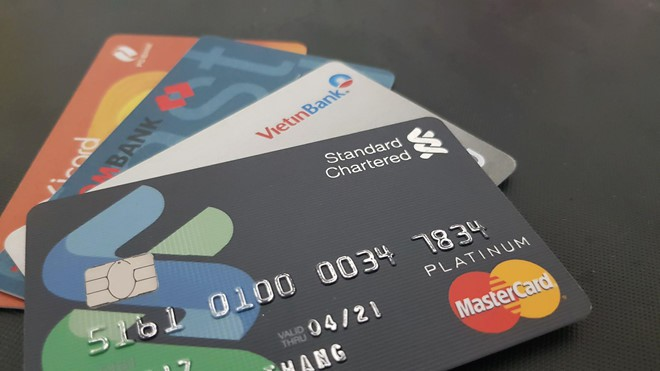

## 📊 REFERENCE LINKS
- Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- Github: https://github.com/trungdung1711/credit_card_fraud_detection



---



## 👇🏻 DATASET DOWNLOADING

In [4]:
! curl -L -o ./creditcardfraud.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud
! mkdir ./dataset
! unzip ./creditcardfraud.zip -d ./dataset
! rm ./creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  14.2M      0  0:00:04  0:00:04 --:--:-- 16.2M
Archive:  ./creditcardfraud.zip
  inflating: ./dataset/creditcard.csv  




---



## 📚 MODULES AND PACKAGES

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

## 🚙 UTIL FUNCTIONS

In [2]:
def print_df(df):
    with pd.option_context("display.max_columns", None):
        display(df.head(2))

def random_color():
    return "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

## 🔢 CONSTANTS

In [3]:
DATASET_DIR = "dataset"
DATASET = "creditcard.csv"

## 🔃 DATA LOADING

In [5]:
df = pd.read_csv(f"./{DATASET_DIR}/{DATASET}")
print_df(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28



---



## 🔍 EXPLORATORY DATA ANALYSIS

### Basic information:
- The dataset contains transactions in September 2013 by European cardholders.
- This dataset contains transactions in two days, where we have 492/284,807 fraud transactions



---



In [7]:
eda_df = df.copy(deep=True)

### What is the class distribution of the dataset?

In [8]:
eda_df["Class"].value_counts()

,count
Class,
0,284315
1,492


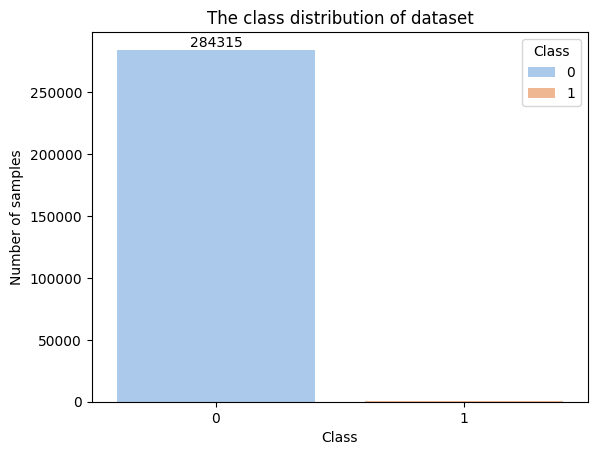

In [8]:
ax = sns.countplot(data=eda_df, x="Class", hue="Class", palette="pastel")
ax.bar_label(ax.containers[0])

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("The class distribution of dataset")
plt.show()

**NOTE**: The dataset is highly imbalanced, as the number of non-fraud transaction is 284315 while the number of fraud transaction only accounts for 492 (0.0172%)

### What do time gaps between transanctions on 2 days look like?

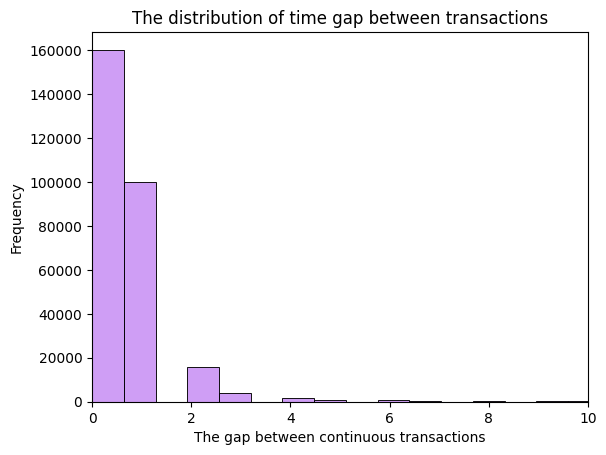

In [9]:
eda_df.sort_values("Time")
eda_df["time_diff"] = eda_df["Time"].diff()

sns.histplot(data=eda_df, x="time_diff", color=random_color(), bins=50)

plt.xlim((0, 10))
plt.xlabel("The gap between continuous transactions")
plt.ylabel("Frequency")
plt.title("The distribution of time gap between transactions")
plt.show()

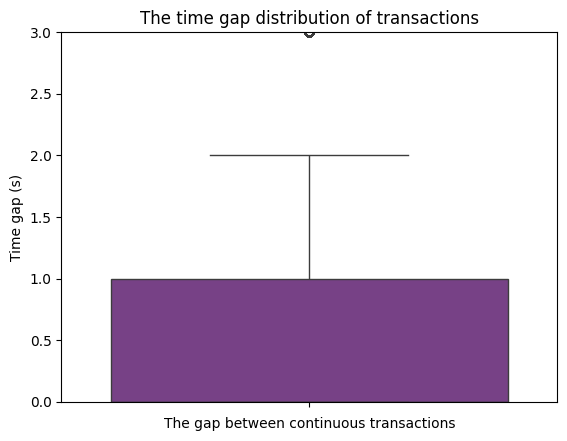

In [10]:
sns.boxplot(data=eda_df, y="time_diff", color=random_color())

plt.ylim((0, 3))
plt.xlabel("The gap between continuous transactions")
plt.ylabel("Time gap (s)")
plt.title("The time gap distribution of transactions")
plt.show()

**NOTE**: Most of the gaps are 0 or 1, and 2, meaning that after a transaction, the next transaction would likely to occur in 1.0 or 2.0 seconds

### What are the number of transactions as the time goes?

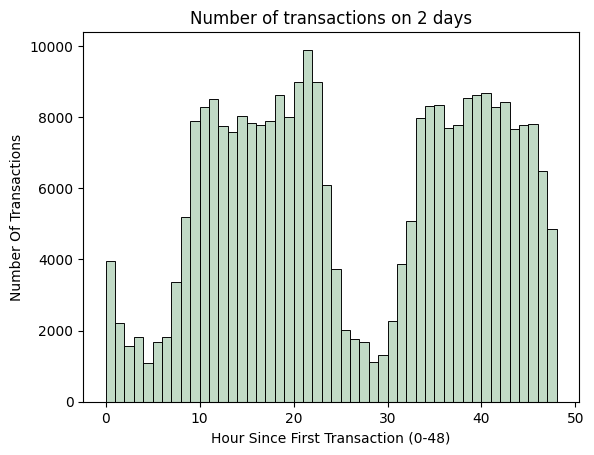

In [11]:
eda_df['hour'] = eda_df['Time'] / 3600

sns.histplot(data=eda_df, x='hour', bins=48, kde=False, color=random_color())
plt.title('Number of transactions on 2 days')
plt.xlabel('Hour Since First Transaction (0-48)')
plt.ylabel("Number Of Transactions")
plt.show()


**NOTE**: It is likely the transactions are recorded from 00:00 (day 1) to 23:59 (day 2), because the number of transactions at the time near midnight seems to decrease significantly, while during the daytime, afternoon, and evening (from 8:00 am to 8:00 pm), the number of transactions seems to remain stable at high frequency (repeating pattern of day 1 and day 2, around 8000 transactions per hour). This makes perfect real world sense

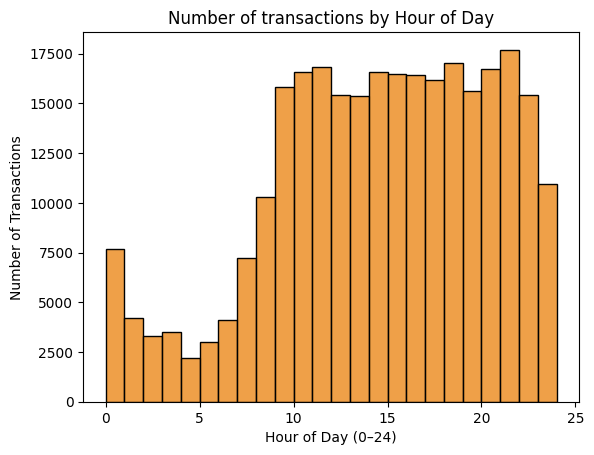

In [12]:
# folds both day together
df['hour_in_day'] = (df['Time'] / 3600) % 24

sns.histplot(df['hour_in_day'], bins=24, color=random_color())
plt.title('Number of transactions by Hour of Day')
plt.xlabel('Hour of Day (0–24)')
plt.ylabel('Number of Transactions')
plt.show()


### Given the class of `fraudulent`, what are the times such that those fraudulent operations usually occur?

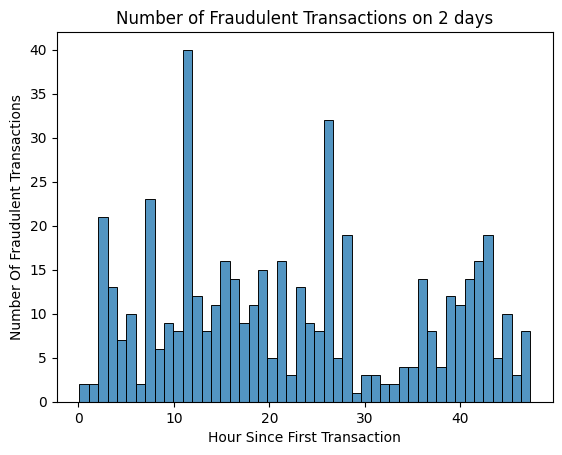

In [13]:
sns.histplot(data=eda_df[eda_df["Class"] == 1], x="hour", bins=48, kde=False, color=random_color())

plt.xlabel("Hour Since First Transaction")
plt.ylabel("Number Of Fraudulent Transactions")
plt.title("Number of Fraudulent Transactions on 2 days")
plt.show()

### What is the transaction distribution by `Amount`?

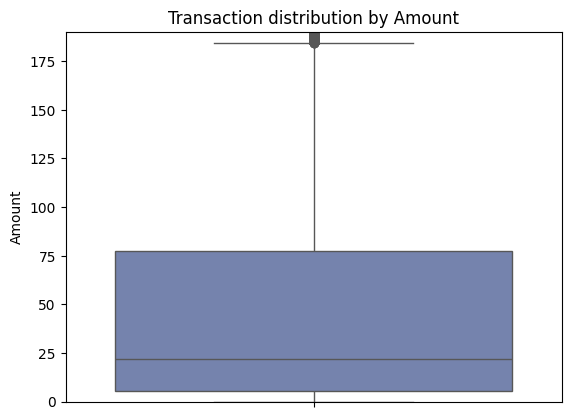

In [14]:
sns.boxplot(data=eda_df, y="Amount", color=random_color())

plt.ylim((0, 190))
plt.ylabel("Amount")
plt.title("Transaction distribution by Amount")
plt.show()

### Given the classes (`normal` and `fraudulent`) transaction, what are the transaction distribution by `Amount`?

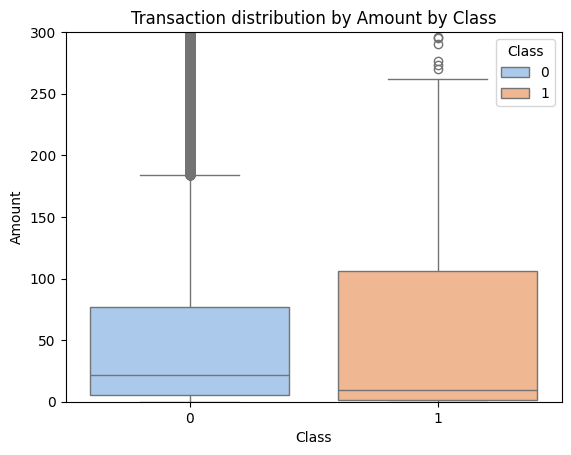

In [15]:
sns.boxplot(data=eda_df, y="Amount", x="Class", palette="pastel", hue="Class")

plt.ylim((0, 300))
plt.title("Transaction distribution by Amount by Class")
plt.ylabel("Amount")
plt.show()

**NOTE**: Given the class (`normal` or `fraudulent`), we can notice that it seems that there is not a huge difference between the `Amount` in 2 types of transactions, in fact, most of the `Amount` of the transactions of the 2 classes, range mostly from 0 to 100$

### What is the `Amount` over times (`Class` separation)?

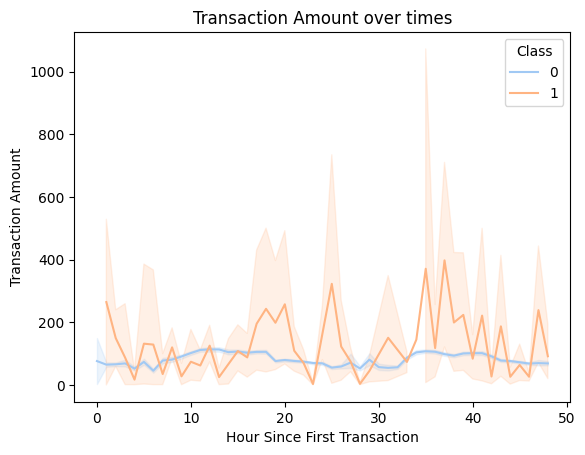

In [16]:
eda_df["hour_bin"] = np.ceil(eda_df["hour"]).astype(int)
sns.lineplot(data=eda_df, x="hour_bin", y="Amount", estimator="mean", hue="Class", palette="pastel")

plt.xlabel("Hour Since First Transaction")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount over times")
plt.legend(title="Class")
plt.show()

**NOTE**: It is explitcitly shown that over time, the `Amount`s of `Fraudulent` transactions are usually higher than `Normal` transactions'. Besides, there is a huge variance on the `Amount` in each hour, but `Normal` transactions' `Amount` keeps a consistent value as time passing. That strengthens the fact that `Amount`s in `Fraudulent` transactions are not always at a high value, but ranging in different values.

### What is the heatmap representing correlation between variables from V1 to V28?

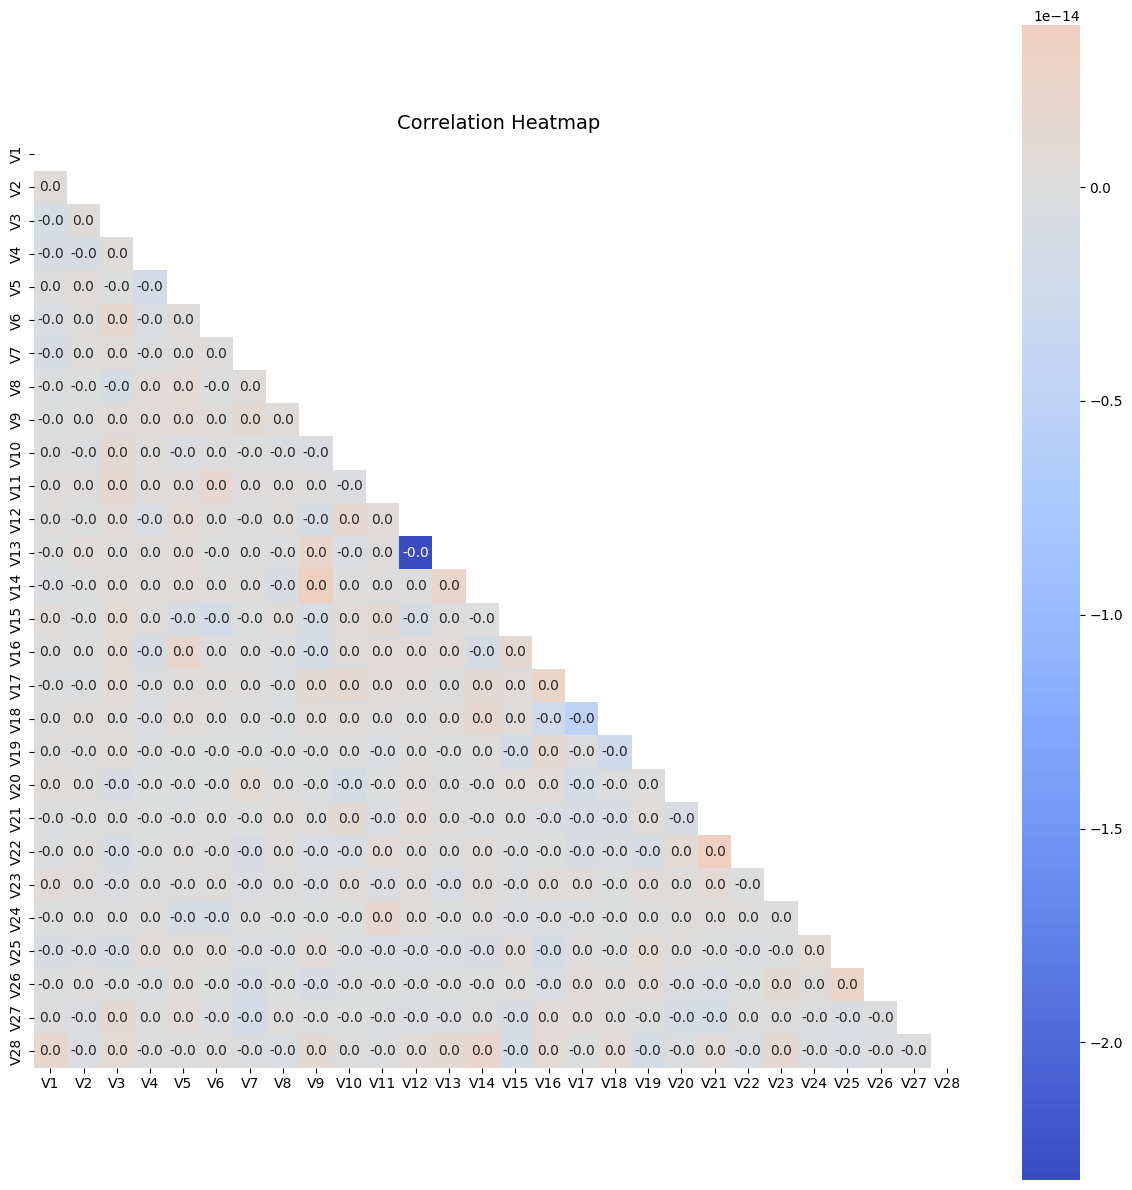

In [17]:

corr = eda_df.drop(columns=["Time", "Amount", "Class", "time_diff", "hour", "hour_bin",]).corr(numeric_only=True)

plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".1f",
    square=True,
    mask=mask
)

plt.title("Correlation Heatmap", fontsize=14)
plt.show()


**NOTE**: Notice that most of the correlation coefficient values are 0.0, which is expected as the data was transformed using PCA technique, which produces features that are uncorrelated to each other (axis orthogonal to each other)

### Given the class, what are the feature distribution (V1-V28)?

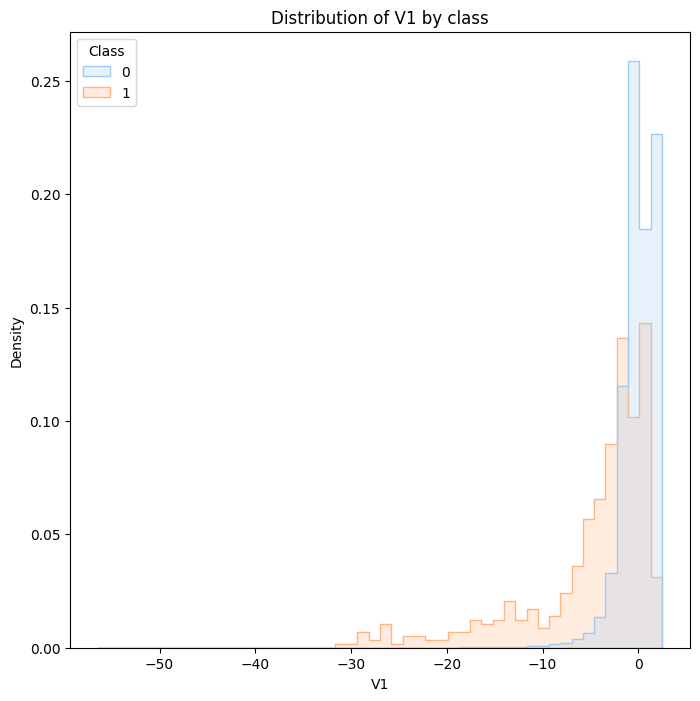

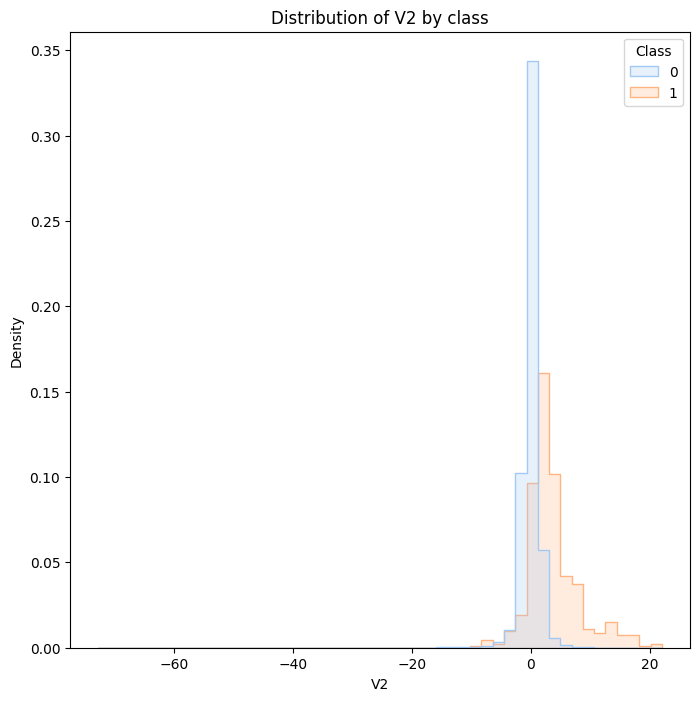

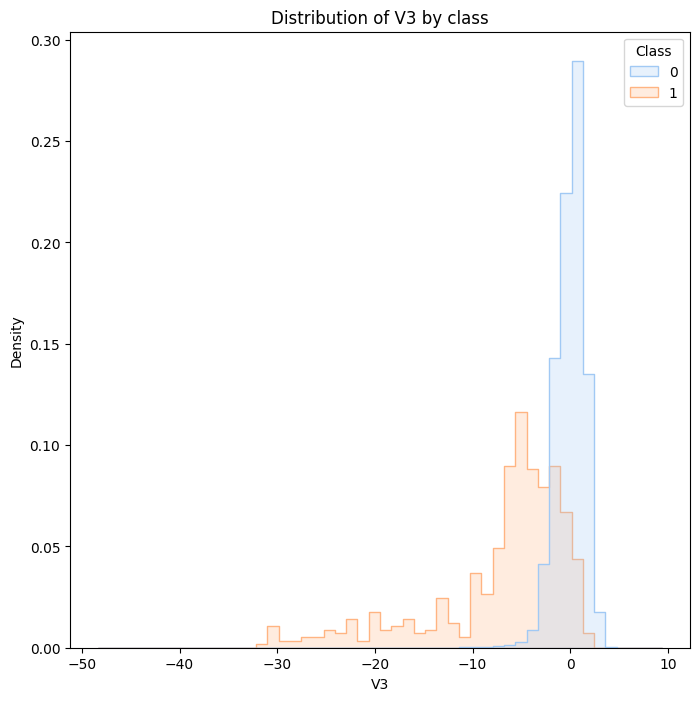

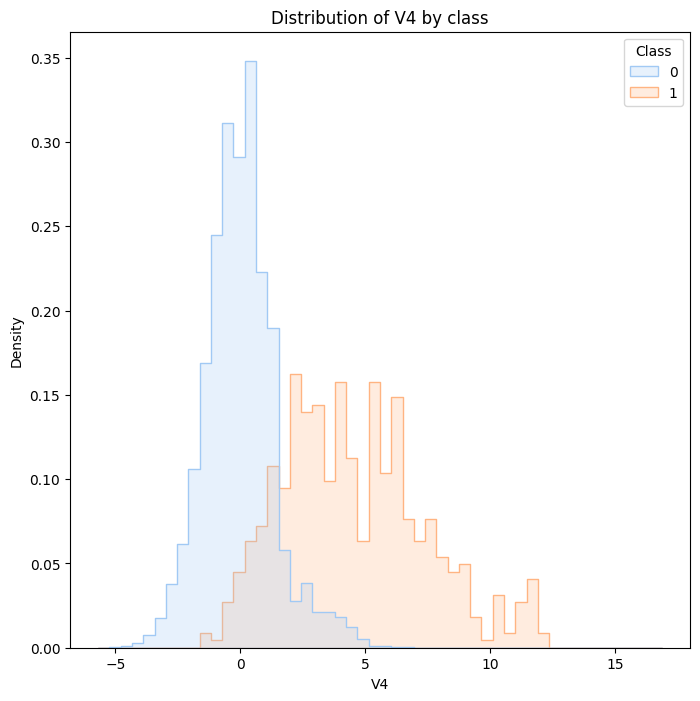

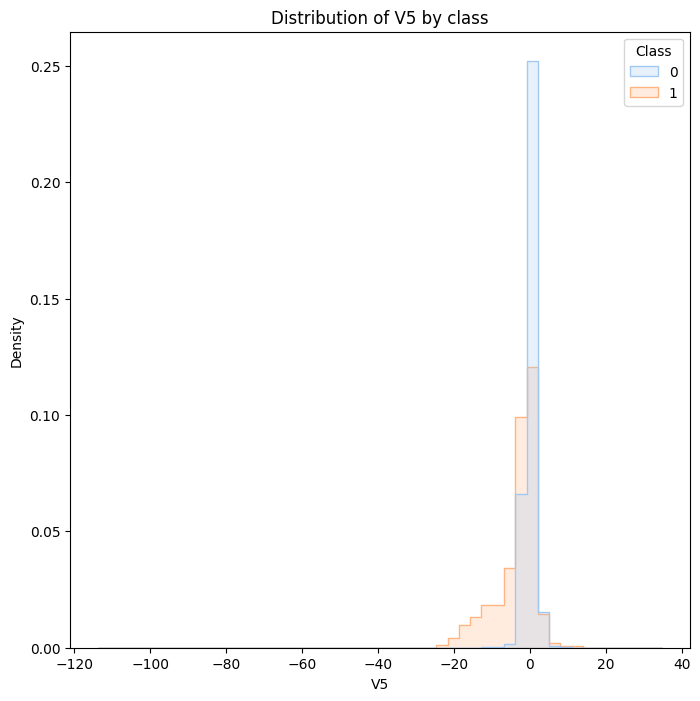

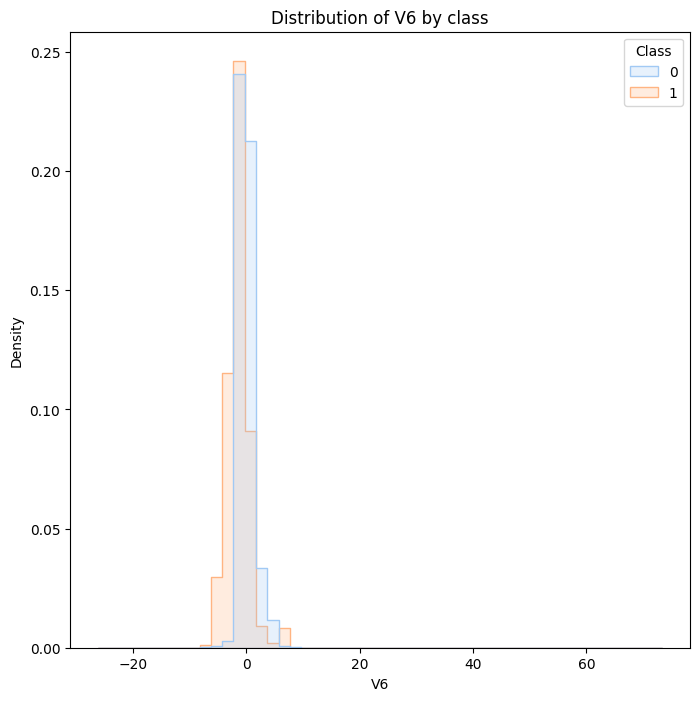

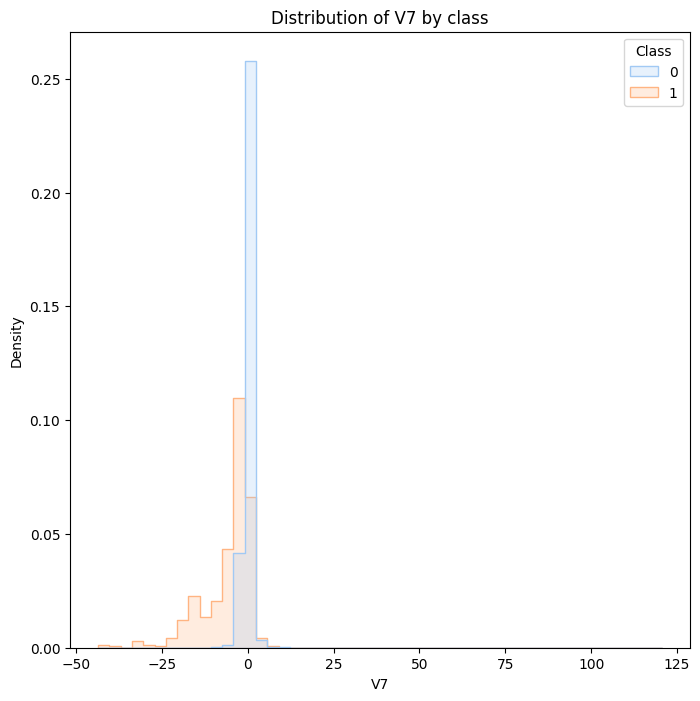

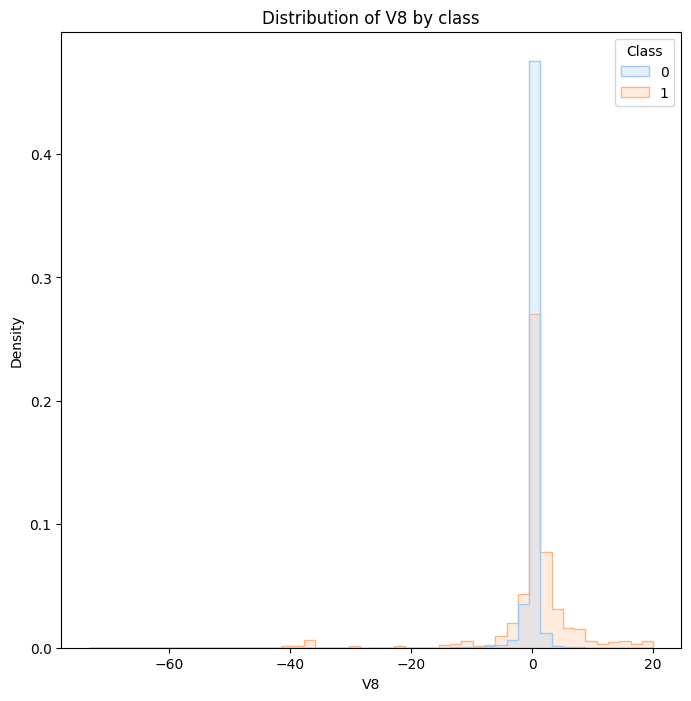

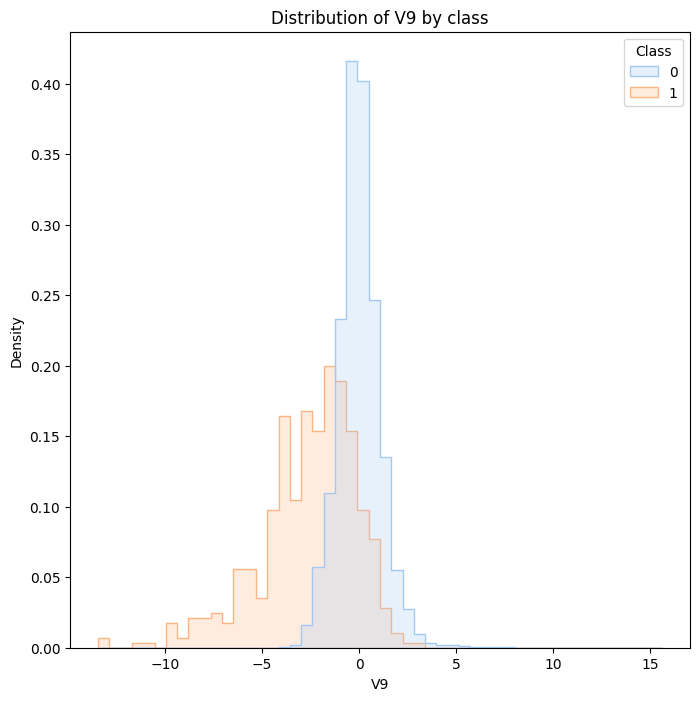

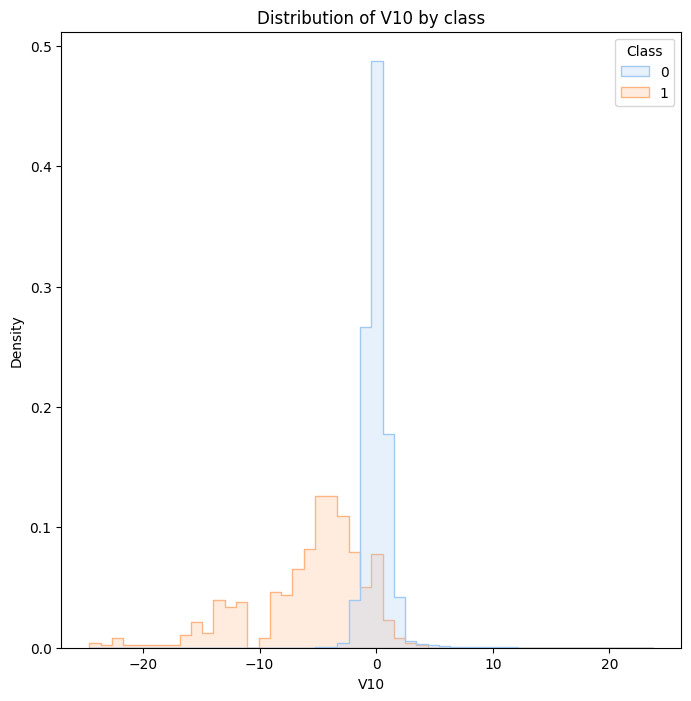

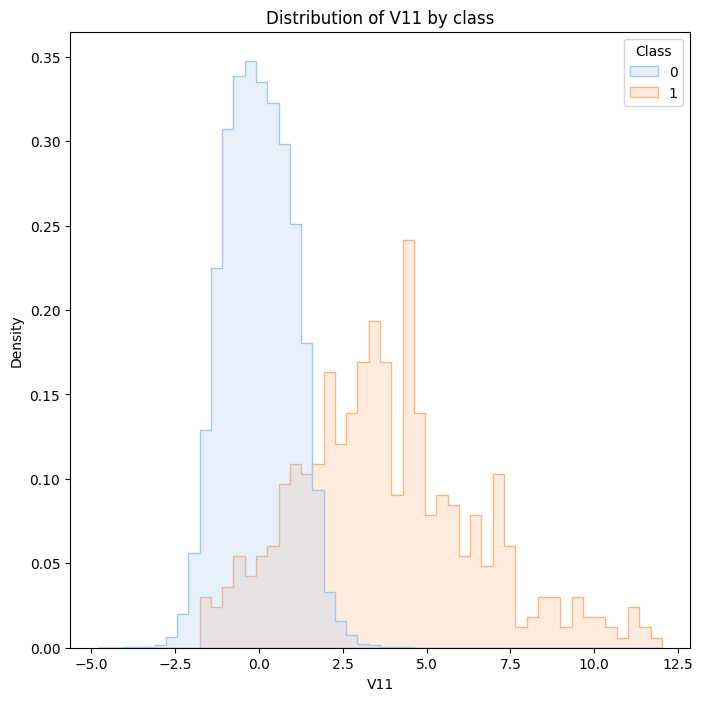

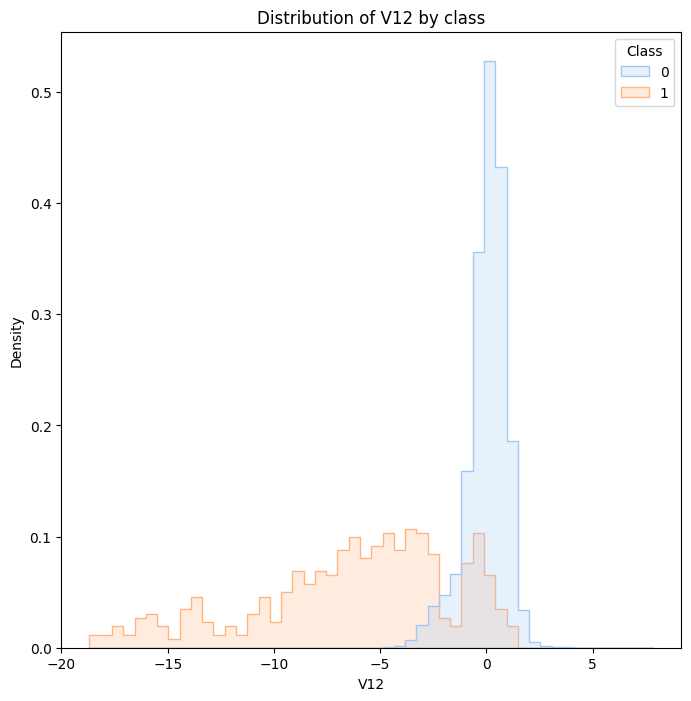

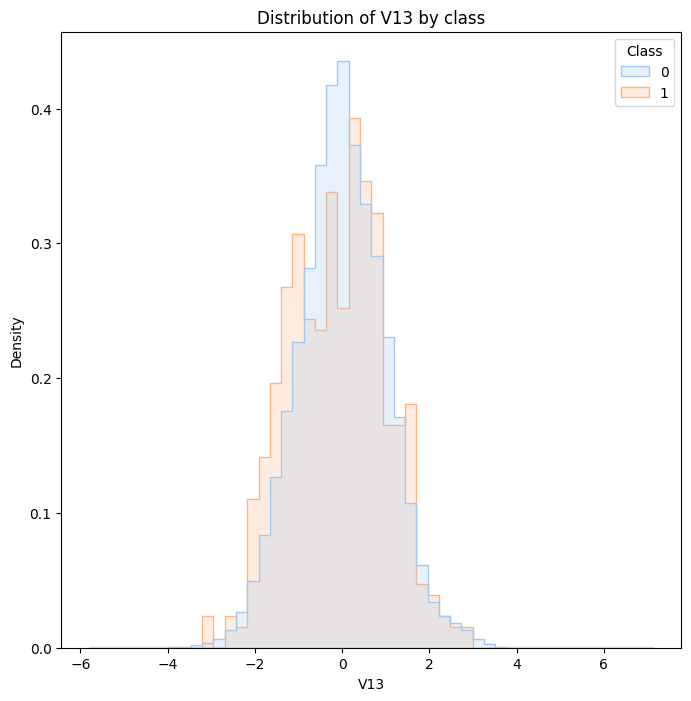

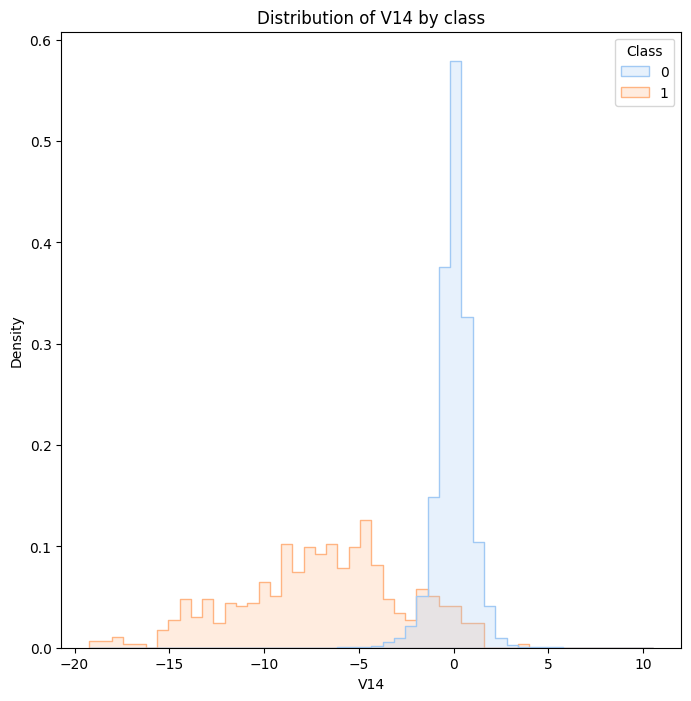

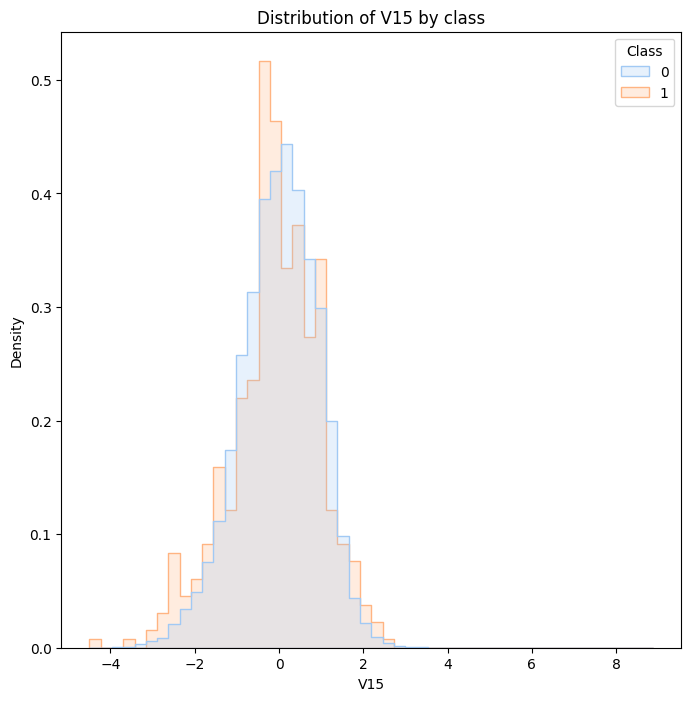

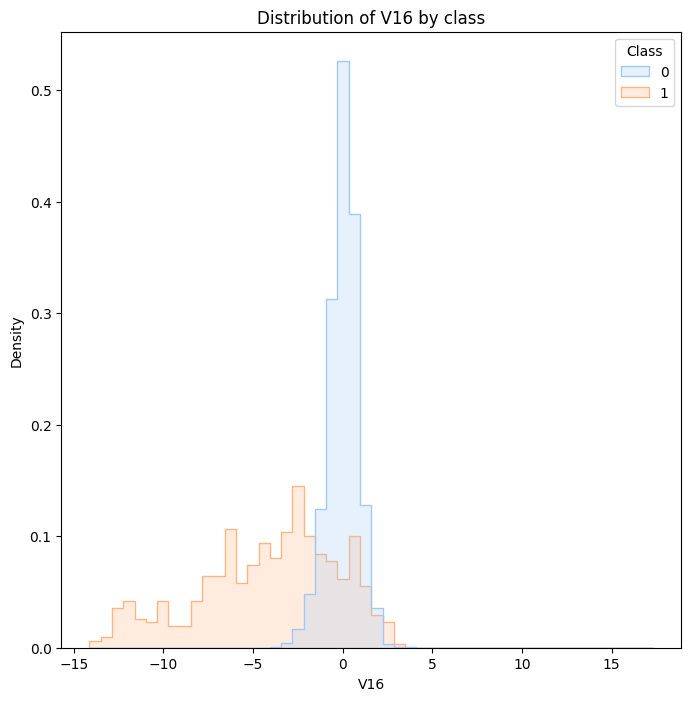

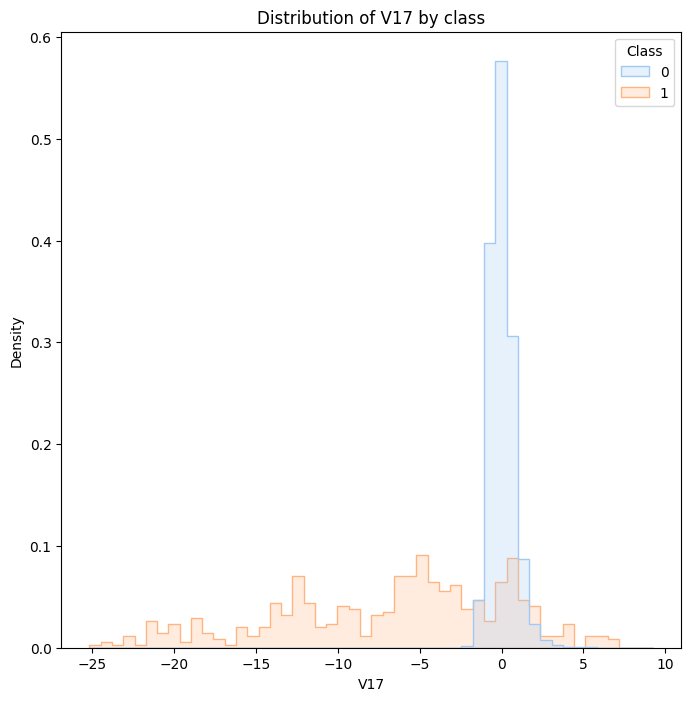

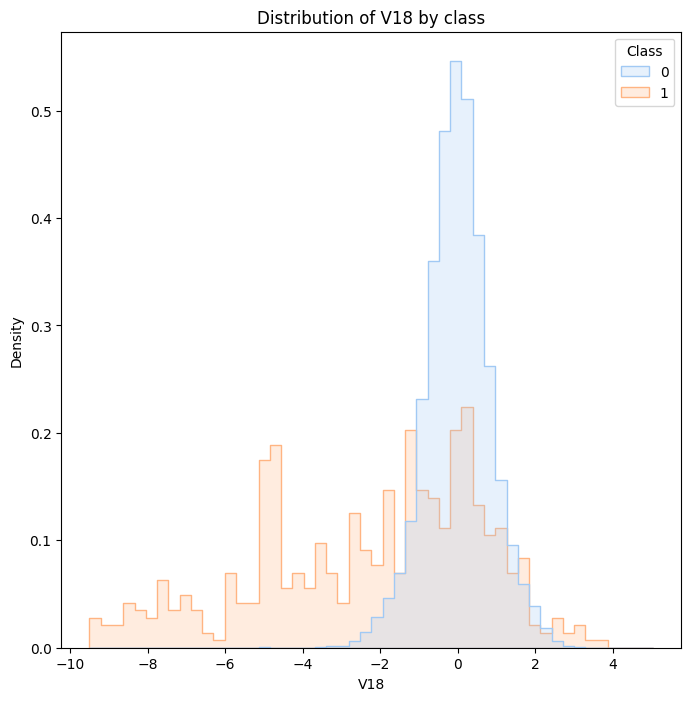

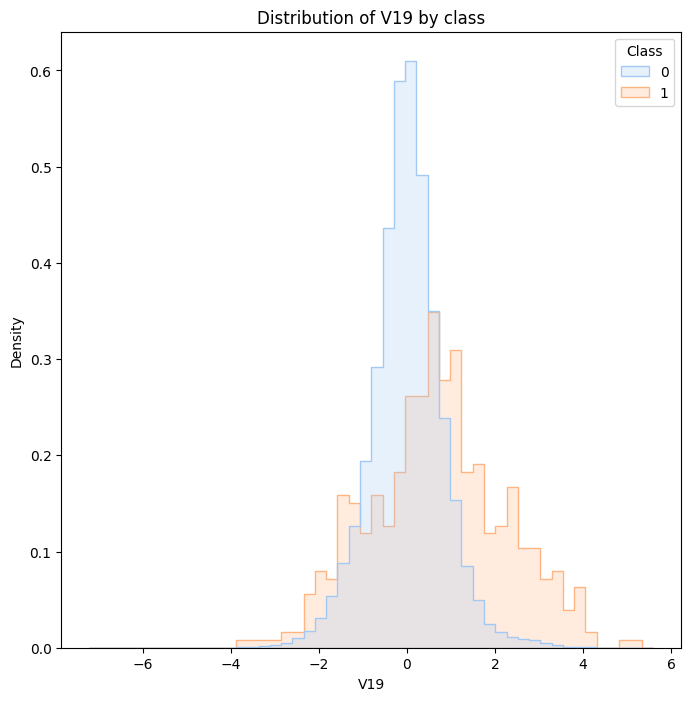

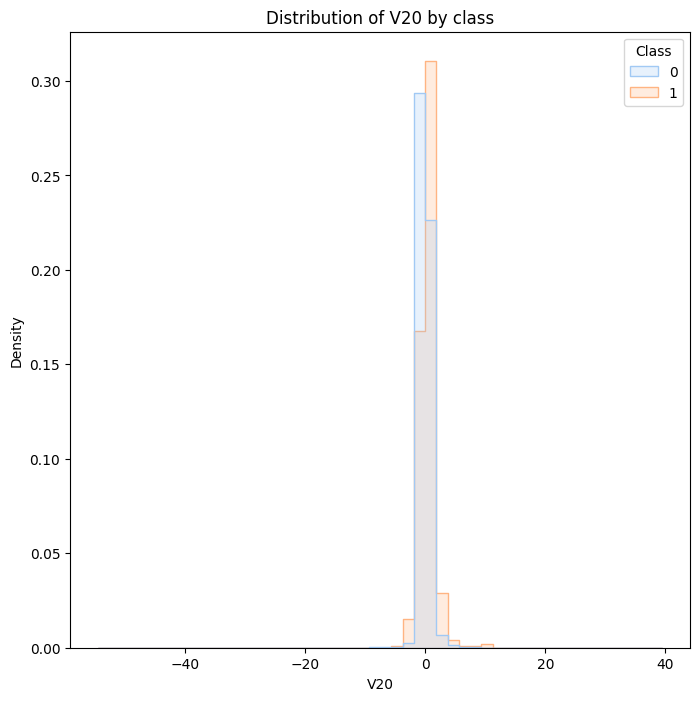

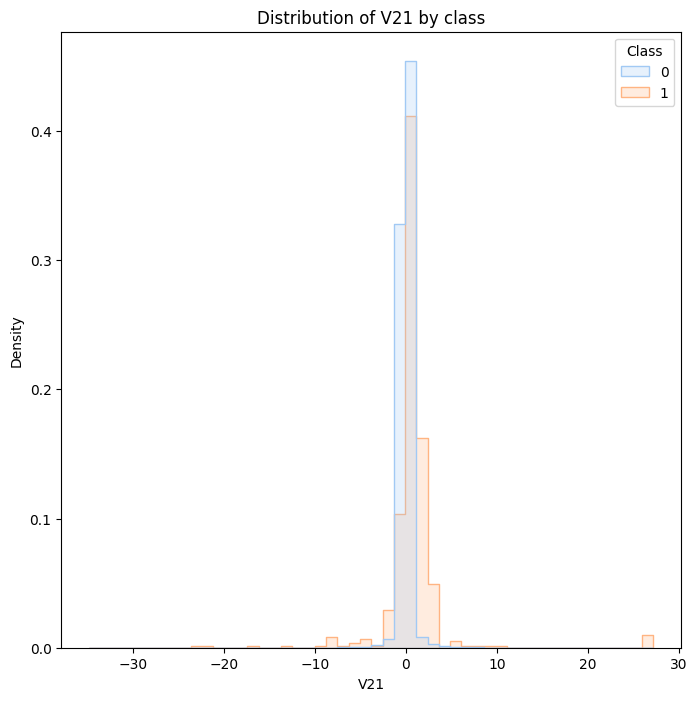

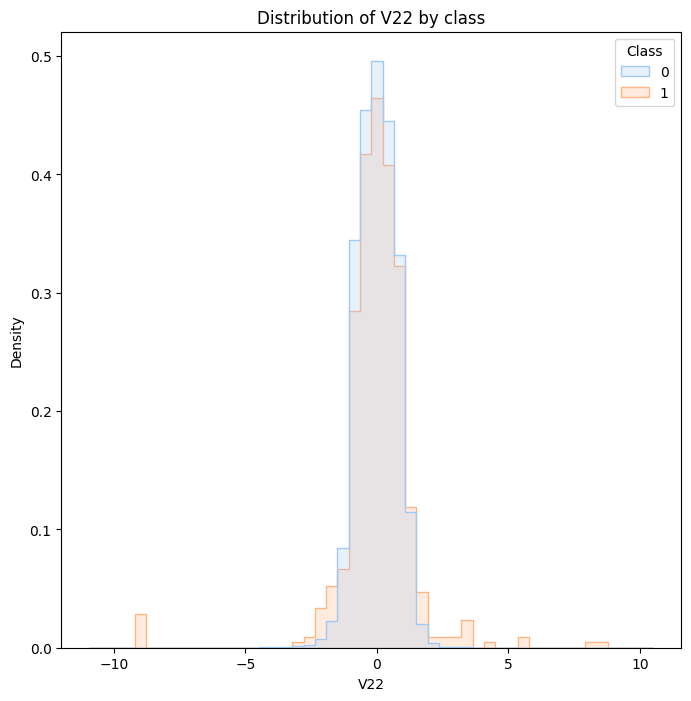

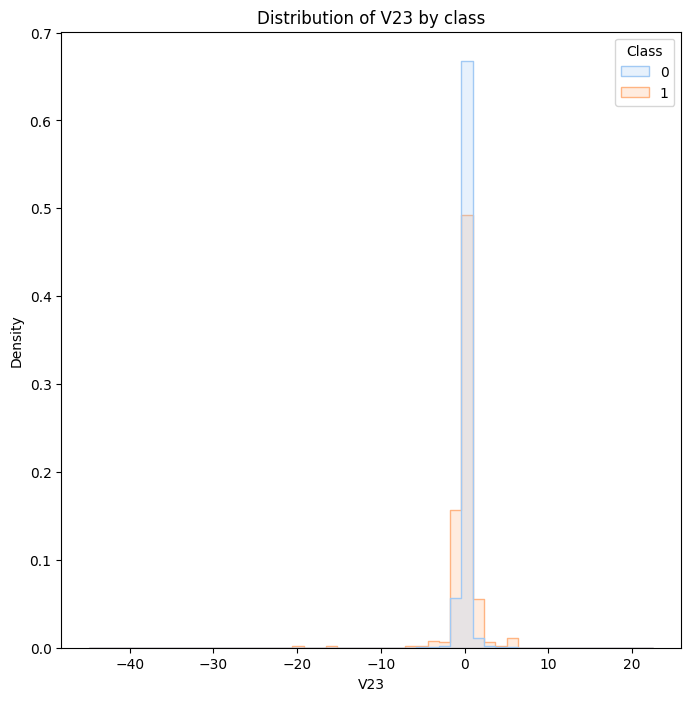

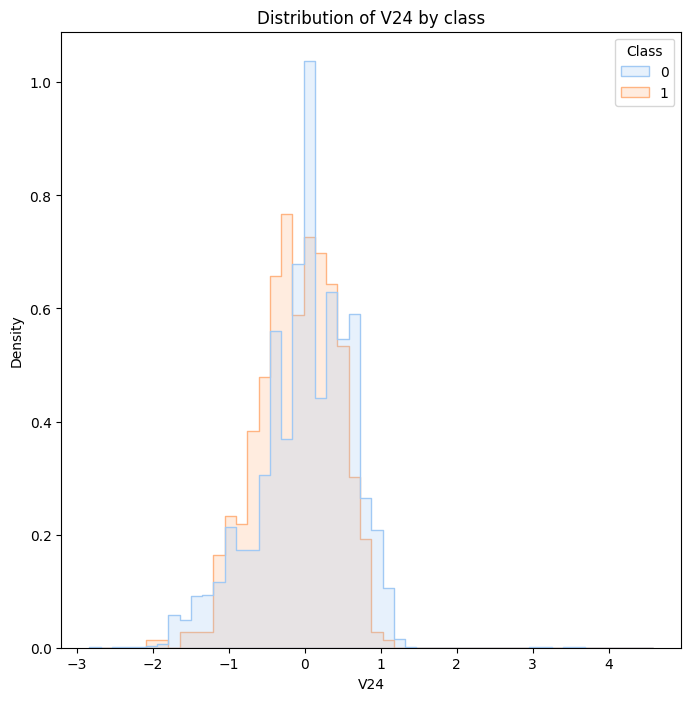

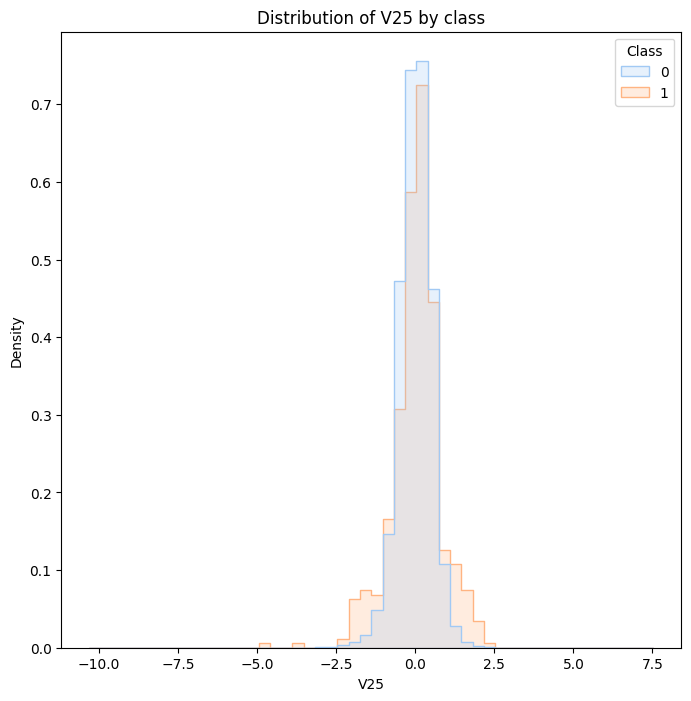

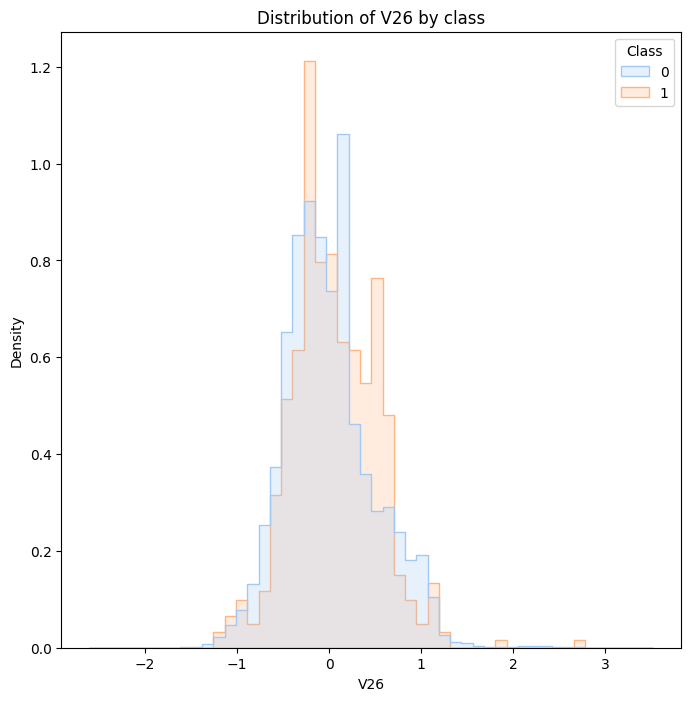

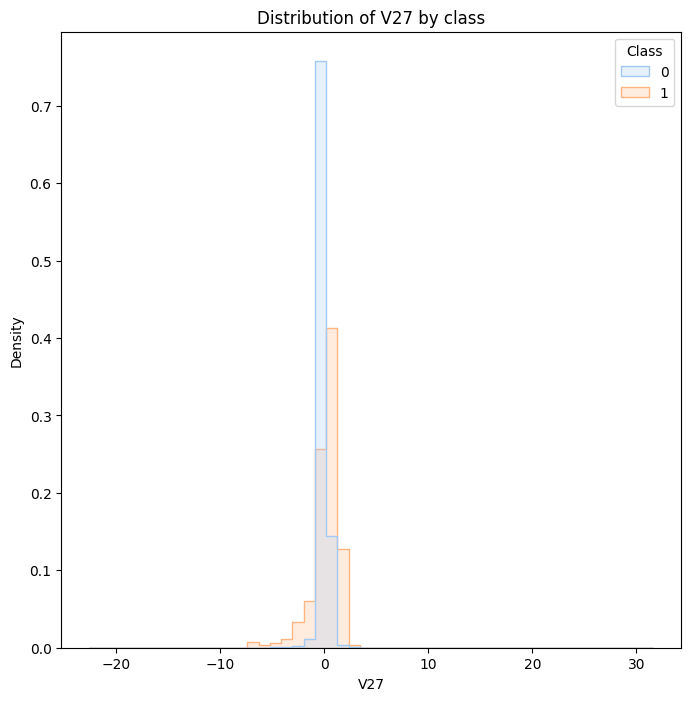

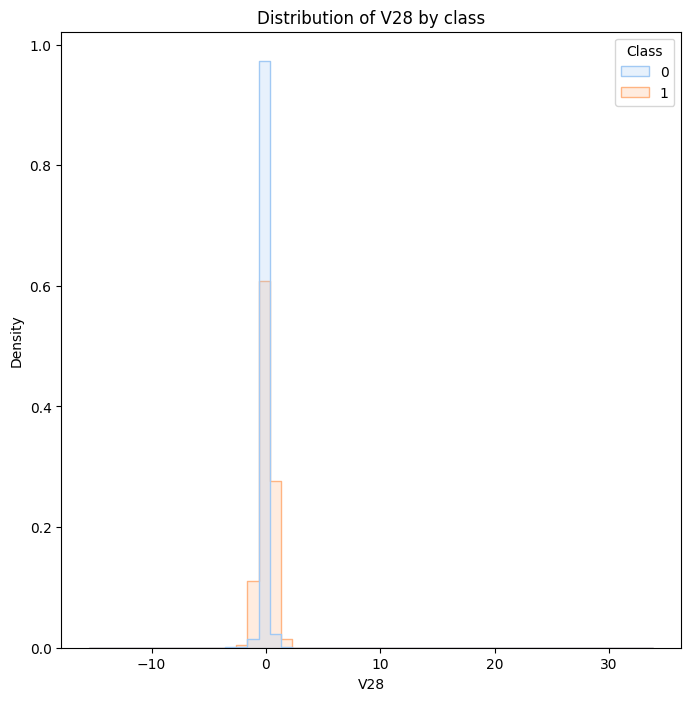

In [18]:
for i in range(1, 29):
  plt.figure(figsize=(8, 8))
  sns.histplot(
      data=eda_df,
      x=f"V{i}",
      hue="Class",
      bins=50,
      element="step",
      stat="density",
      palette="pastel",
      common_norm=False   # normalize each class separately
  )

  plt.title(f"Distribution of V{i} by class")
  plt.show()


**NOTE**: Knowing the class, `V4`, `V11` has nearly different probability distributions, while `V15`, `V19`, `V22`, `V24`, `V25`, `V26`, `V27`, `V28` actually have similar probability. In the case of similar probability, when using those features (in Naive Bayes), given those features, it doesn't provide much information to the posterior probability (because the two P(X | class_i) would nearly be the same, the posterior probability would depend on the prior probability

## 🤹DEALING WITH IMBALANCED DATASET

## 🧑‍💻 MODEL TRANINING

## ⚖️ MODEL EVALUATION

## 🔭 EXTENSION USING NEURAL NETWORK MODEL



---



## 📝NOTES

- `Undersampling` and `Oversampling`
- Lower the threshold (as A `False Negative` is considered to be very dangerous)
- `Backward elimination`
- `Naive Bayes` (Gausian distribution)
- Have to understand `SMOTE` (or skip it)

## 🙈 AUTHOR

-
-
-
- LE BUI TRUNG DUNG

In [ ]:

# ==============================================================
# 1. Import thư viện
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# ==============================================================
# 2. Đọc dữ liệu và hiển thị thông tin dữ liệu
# ==============================================================
df = pd.read_csv("/content/sample_data/creditcard.csv")
# df = pd.read_csv("creditcard.csv")

print(df.head())
print(df.info())
print("\nTỷ lệ lớp (Class):")
print(df["Class"].value_counts(normalize=True))
print( df.describe())

# ==============================================================
# 3. Vẽ ma trận tương quan giữa các thuộc tính
# ==============================================================
# Tạo thư mục lưu hình ảnh
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(12,10))
corr = df.corr()

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Ma trận tương quan giữa các thuộc tính")
plt.tight_layout()
plt.savefig("figures/correlation_matrix.png", dpi=150)
plt.close()

# ==============================================================
# 4. Chuẩn bị dữ liệu
# ==============================================================
X = df.drop(columns=["Class", "Time"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================================================
# 5. Áp dụng SMOTE để cân bằng dữ liệu cho việc đánh giá trên tập test
# ==============================================================
# Chuẩn hóa cột Amount, Comment lại khi đánh giá mô hình
# scaler = StandardScaler()
# X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
# X_test["Amount"] = scaler.transform(X_test[["Amount"]])

# smote = SMOTE(sampling_strategy=0.2, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# print("\nPhân phối lớp trước và sau SMOTE:")
# print("Trước SMOTE:", np.bincount(y_train))
# print("Sau SMOTE:", np.bincount(y_train_res))

# ==============================================================
# 6. Vẽ phân phối của từng feature theo Class và sau SMOTE
# ==============================================================
# features = [c for c in df.columns if c not in ["Class", "Time"]]

# # Tạo DataFrame sau SMOTE để trực quan
# X_smote_df = pd.DataFrame(X_train_res, columns=X.columns)
# X_smote_df["Class"] = y_train_res.values

# for col in features:
#     plt.figure(figsize=(6, 4))
#     # Phân phối gốc
#     sns.kdeplot(data=df[df["Class"] == 0], x=col, label="Class 0 (gốc)", fill=True, alpha=0.4)
#     sns.kdeplot(data=df[df["Class"] == 1], x=col, label="Class 1 (gốc)", fill=True, alpha=0.4, color="r")

#     # Phân phối sau SMOTE
#     sns.kdeplot(
#     data=X_smote_df[X_smote_df["Class"] == 1],
#     x=col, label="Class 1 (sau SMOTE)", fill=False, color="green", linestyle="--"
#     )

#     plt.title(f"Phân phối đặc trưng {col}\n(Class 0, Class 1 gốc, Class 1 sau SMOTE)")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"figures/feature_distribution_{col}_with_smote.png", dpi=150)
#     plt.close()

# ==============================================================
# 7. Hàm đánh giá mô hình bằng K-Fold (trả về trung bình các metrics)
# ==============================================================

def evaluate_model_kfold(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} không smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


def evaluate_model_kfold_smote(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} có smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    smote = SMOTE(sampling_strategy=0.2, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Cân bằng dữ liệu bằng SMOTE
        X_res, y_res = smote.fit_resample(X_train, y_train)

        # Train
        model.fit(X_res, y_res)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


# ==============================================================
# 8. Danh sách mô hình và bộ tham số cần thử nghiệm
# ==============================================================
model_configs = [
    # Logistic Regression
    (
        LogisticRegression(random_state=42, max_iter=1000),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # Random Forest
    (
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # SVC
    (
        SVC(probability=True, random_state=42),
        [
            {"kernel": "rbf"},
            {"kernel": "poly"},
            {"kernel": "linear"},
            {"class_weight": "balanced", "kernel": "poly"},
        ]
    )
]


# ==============================================================
# 9. Chạy đánh giá
# ==============================================================
results = []
for model, param_list in model_configs:
    for params in param_list:
        model_name = repr(model)
        result = evaluate_model_kfold(model, params, X_train, y_train, model_name, k=4)
        # result = evaluate_model_kfold_smote(model, params, X_train, y_train, model_name, k=4)
        results.append(result)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False, inplace=True)

print("\n===== KẾT QUẢ TỔNG HỢP =====")
print(results_df)
# ======= Xuất ra file CSV =======
results_df.to_csv("figures/results.csv", index=False, encoding="utf-8-sig")

# ==============================================================
# 10. Huấn luyện mô hình chạy trên tập test
# ==============================================================
# model = RandomForestClassifier(
#     n_estimators=200,
#     random_state=42,
#     n_jobs=-1,
#     # class_weight="balanced_subsample"
# )
# model = SVC(probability=True, random_state=42, kernel="rbf")
# # No SMOTE
# model.fit(X_train, y_train)
# # SMOTE
# # model.fit(X_train_res, y_train_res)
#
# Dự đoán
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# # Đánh giá
# # Tạo confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# labels = ["Class 0 (Normal)", "Class 1 (Fraud)"]

# # Vẽ biểu đồ heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.savefig("figures/confusion_matrix.png", dpi=150)

# print("\nConfusion Matrix:\n", cm)
# print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# # ==============================================================
# # 8. Vẽ feature importance
# # ==============================================================
# importances = model.feature_importances_
# feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
# plt.figure(figsize=(8,6))
# sns.barplot(x=feat_imp[:], y=feat_imp.index[:])
# plt.title("Top 10 Feature Importance (RandomForest)")
# plt.tight_layout()
# plt.savefig("figures/feature_importance.png", dpi=150)
# plt.close()



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:

# ==============================================================
# 1. Import thư viện
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# ==============================================================
# 2. Đọc dữ liệu và hiển thị thông tin dữ liệu
# ==============================================================
df = pd.read_csv("/content/sample_data/creditcard.csv")
# df = pd.read_csv("creditcard.csv")

print(df.head())
print(df.info())
print("\nTỷ lệ lớp (Class):")
print(df["Class"].value_counts(normalize=True))
print( df.describe())

# ==============================================================
# 3. Vẽ ma trận tương quan giữa các thuộc tính
# ==============================================================
# Tạo thư mục lưu hình ảnh
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(12,10))
corr = df.corr()

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Ma trận tương quan giữa các thuộc tính")
plt.tight_layout()
plt.savefig("figures/correlation_matrix.png", dpi=150)
plt.close()

# ==============================================================
# 4. Chuẩn bị dữ liệu
# ==============================================================
X = df.drop(columns=["Class", "Time"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================================================
# 5. Áp dụng SMOTE để cân bằng dữ liệu cho việc đánh giá trên tập test
# ==============================================================
# Chuẩn hóa cột Amount, Comment lại khi đánh giá mô hình
# scaler = StandardScaler()
# X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
# X_test["Amount"] = scaler.transform(X_test[["Amount"]])

# smote = SMOTE(sampling_strategy=0.2, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# print("\nPhân phối lớp trước và sau SMOTE:")
# print("Trước SMOTE:", np.bincount(y_train))
# print("Sau SMOTE:", np.bincount(y_train_res))

# ==============================================================
# 6. Vẽ phân phối của từng feature theo Class và sau SMOTE
# ==============================================================
# features = [c for c in df.columns if c not in ["Class", "Time"]]

# # Tạo DataFrame sau SMOTE để trực quan
# X_smote_df = pd.DataFrame(X_train_res, columns=X.columns)
# X_smote_df["Class"] = y_train_res.values

# for col in features:
#     plt.figure(figsize=(6, 4))
#     # Phân phối gốc
#     sns.kdeplot(data=df[df["Class"] == 0], x=col, label="Class 0 (gốc)", fill=True, alpha=0.4)
#     sns.kdeplot(data=df[df["Class"] == 1], x=col, label="Class 1 (gốc)", fill=True, alpha=0.4, color="r")

#     # Phân phối sau SMOTE
#     sns.kdeplot(
#     data=X_smote_df[X_smote_df["Class"] == 1],
#     x=col, label="Class 1 (sau SMOTE)", fill=False, color="green", linestyle="--"
#     )

#     plt.title(f"Phân phối đặc trưng {col}\n(Class 0, Class 1 gốc, Class 1 sau SMOTE)")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"figures/feature_distribution_{col}_with_smote.png", dpi=150)
#     plt.close()

# ==============================================================
# 7. Hàm đánh giá mô hình bằng K-Fold (trả về trung bình các metrics)
# ==============================================================

def evaluate_model_kfold(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} không smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


def evaluate_model_kfold_smote(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} có smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    smote = SMOTE(sampling_strategy=0.2, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Cân bằng dữ liệu bằng SMOTE
        X_res, y_res = smote.fit_resample(X_train, y_train)

        # Train
        model.fit(X_res, y_res)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


# ==============================================================
# 8. Danh sách mô hình và bộ tham số cần thử nghiệm
# ==============================================================
model_configs = [
    # Logistic Regression
    (
        LogisticRegression(random_state=42, max_iter=1000),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # Random Forest
    (
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # SVC
    (
        SVC(probability=True, random_state=42),
        [
            {"kernel": "rbf"},
            {"kernel": "poly"},
            {"kernel": "linear"},
            {"class_weight": "balanced", "kernel": "poly"},
        ]
    )
]


# ==============================================================
# 9. Chạy đánh giá
# ==============================================================
results = []
for model, param_list in model_configs:
    for params in param_list:
        model_name = repr(model)
        # result = evaluate_model_kfold(model, params, X_train, y_train, model_name, k=4)
        result = evaluate_model_kfold_smote(model, params, X_train, y_train, model_name, k=4)
        results.append(result)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False, inplace=True)

print("\n===== KẾT QUẢ TỔNG HỢP =====")
print(results_df)
# ======= Xuất ra file CSV =======
results_df.to_csv("figures/results.csv", index=False, encoding="utf-8-sig")

# ==============================================================
# 10. Huấn luyện mô hình chạy trên tập test
# ==============================================================
# model = RandomForestClassifier(
#     n_estimators=200,
#     random_state=42,
#     n_jobs=-1,
#     # class_weight="balanced_subsample"
# )
# model = SVC(probability=True, random_state=42, kernel="rbf")
# # No SMOTE
# model.fit(X_train, y_train)
# # SMOTE
# # model.fit(X_train_res, y_train_res)
#
# Dự đoán
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# # Đánh giá
# # Tạo confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# labels = ["Class 0 (Normal)", "Class 1 (Fraud)"]

# # Vẽ biểu đồ heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.savefig("figures/confusion_matrix.png", dpi=150)

# print("\nConfusion Matrix:\n", cm)
# print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# # ==============================================================
# # 8. Vẽ feature importance
# # ==============================================================
# importances = model.feature_importances_
# feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
# plt.figure(figsize=(8,6))
# sns.barplot(x=feat_imp[:], y=feat_imp.index[:])
# plt.title("Top 10 Feature Importance (RandomForest)")
# plt.tight_layout()
# plt.savefig("figures/feature_importance.png", dpi=150)
# plt.close()

